In [1]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 12.1 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Conv1D, Dropout, ReLU, Add, Dense, BatchNormalization, Reshape, Flatten
from tensorflow_addons.layers import WeightNormalization
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN
import seaborn as sn
import collections
import pandas as pd 

2.8.0
Num GPUs Available:  1


# 加载原始数据

In [3]:
file = r'/content/drive/MyDrive/Colab Notebooks/methods/win_9_overlap_4.5.mat'
data = loadmat(file, mat_dtype=True)
motion_py1 = data['out_feature']
x = motion_py1[:,0:180]
y = motion_py1[:,180]
y = y.astype(int)


num_classes = 2
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(x, y, test_size = 0.30, random_state = 50)
X_test, X_val, label_test, label_val = train_test_split(X_test_a, y_test_a, test_size = 0.50, random_state = 50)

X_train, label_train = ADASYN().fit_resample(X_train_a, y_train_a)

# X_train, label_train = X_train_a, y_train_a

y_train = tf.keras.utils.to_categorical(label_train,num_classes)
y_test = tf.keras.utils.to_categorical(label_test,num_classes)
y_val = tf.keras.utils.to_categorical(label_val,num_classes)
X_train.shape, X_test.shape, X_val.shape

((51198, 180), (5947, 180), (5948, 180))

# 搭建TCN模型

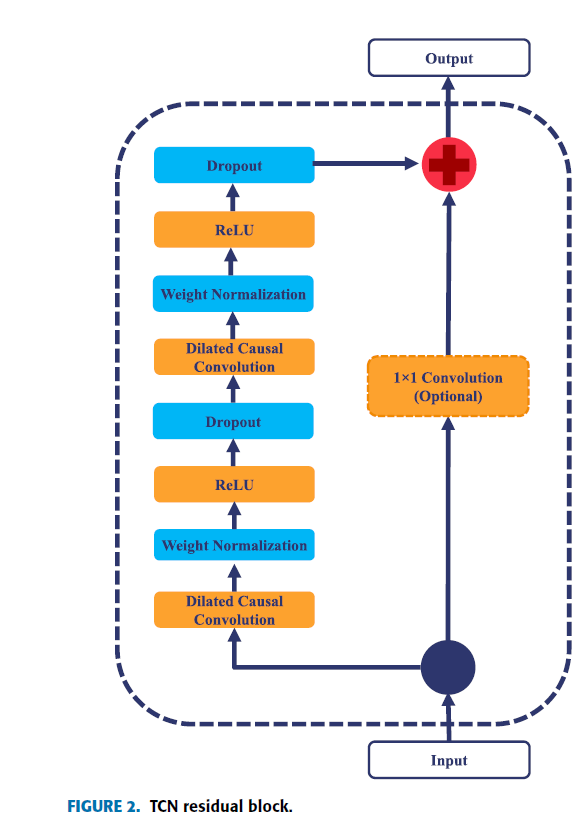

In [4]:
def MyModel(time_periods, num_channels, num_classes):
  input_xs = Input([time_periods, num_channels])
  conv_1 = WeightNormalization(Conv1D(filters=175, kernel_size=5, activation=tf.nn.relu, padding="causal"))(input_xs)
  output = ReLU()(conv_1)
  output = Dropout(0.1)(output)
  conv_2 = WeightNormalization(Conv1D(filters=175, kernel_size=5, activation=tf.nn.relu, padding="causal"))(output)
  output = ReLU()(conv_2)
  output = Dropout(0.1)(output)
  output2 = Conv1D(filters=175, kernel_size=5, activation=tf.nn.relu, padding="SAME")(input_xs)
  out = Add()([output2, output])
  flat = Flatten()(out)
  dense = Dense(64, activation=tf.nn.relu)(flat)
  dense = BatchNormalization()(dense)
  logits = Dense(num_classes, activation=tf.nn.softmax)(flat)
  model = Model(inputs = input_xs, outputs = logits)
  return model

time_periods = 180
num_channels = 1
num_classes = 2

TCN_model = MyModel(time_periods, num_channels, num_classes)
TCN_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 1)]     0           []                               
                                                                                                  
 weight_normalization (WeightNo  (None, 180, 175)    2276        ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 re_lu (ReLU)                   (None, 180, 175)     0           ['weight_normalization[0][0]']   
                                                                                                  
 dropout (Dropout)              (None, 180, 175)     0           ['re_lu[0][0]']              

In [5]:
epochs = 100
batch_size = 32

"""
def decayed_learning_rate(step):
  return initial_learning_rate / (1 + decay_rate * step / decay_step)
"""

initial_learning_rate = 1.e-4
decay_steps = 1
decay_rate = 0.09

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate,
  decay_steps,
  decay_rate,
  staircase=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

TCN_model.compile(
        loss = tf.keras.losses.BinaryFocalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
        metrics = ['accuracy'])

history = TCN_model.fit(  
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data = (X_val, y_val),
            # callbacks=[early_stopping,lr_decay])
            callbacks=[early_stopping])

Epoch 1/100
1600/1600 [==============================] - 26s 7ms/step - loss: 7.5006 - accuracy: 0.5105 - val_loss: 11.2244 - val_accuracy: 0.2677
Epoch 2/100
1600/1600 [==============================] - 10s 6ms/step - loss: 7.4227 - accuracy: 0.5153 - val_loss: 1.1474 - val_accuracy: 0.9252
Epoch 3/100
1600/1600 [==============================] - 10s 6ms/step - loss: 7.6608 - accuracy: 0.5005 - val_loss: 1.1474 - val_accuracy: 0.9252
Epoch 4/100
1600/1600 [==============================] - 10s 6ms/step - loss: 7.6608 - accuracy: 0.5005 - val_loss: 1.1474 - val_accuracy: 0.9252
Epoch 5/100
1600/1600 [==============================] - 10s 6ms/step - loss: 7.6608 - accuracy: 0.5005 - val_loss: 1.1474 - val_accuracy: 0.9252
Epoch 6/100
1600/1600 [==============================] - 10s 6ms/step - loss: 7.6608 - accuracy: 0.5005 - val_loss: 1.1474 - val_accuracy: 0.9252
Epoch 7/100
1600/1600 [==============================] - 10s 7ms/step - loss: 7.6607 - accuracy: 0.5005 - val_loss: 1.1474 

Test accuracy: 0.931226
Kappa: 0.000000
F1-score: 0.482194


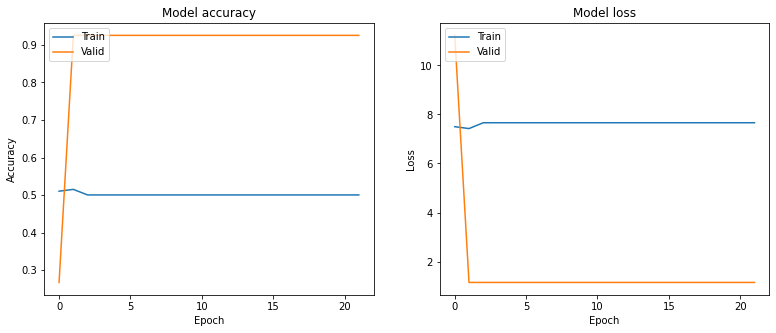

In [6]:
y_pre = np.argmax(TCN_model.predict(X_test), axis=-1)
y_pre = y_pre.astype(int)
accuracy = metrics.accuracy_score(label_test, y_pre)  # 计算准确度
kappa = metrics.cohen_kappa_score(label_test, y_pre)  # 计算kappa
f1_score = metrics.f1_score(label_test, y_pre, average='macro')
print("Test accuracy: {:.6f}".format(accuracy))
print("Kappa: {:.6f}".format(kappa))
print("F1-score: {:.6f}".format(f1_score))


# 绘制训练 & 验证的准确率值 
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid'], loc='upper left')  
# plt.savefig('Valid_acc.png')  
 
# 绘制训练 & 验证的损失值  
plt.subplot(1,2,2)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid'], loc='upper left')  
plt.show()

Text(0.5, 1.0, 'Quantity')

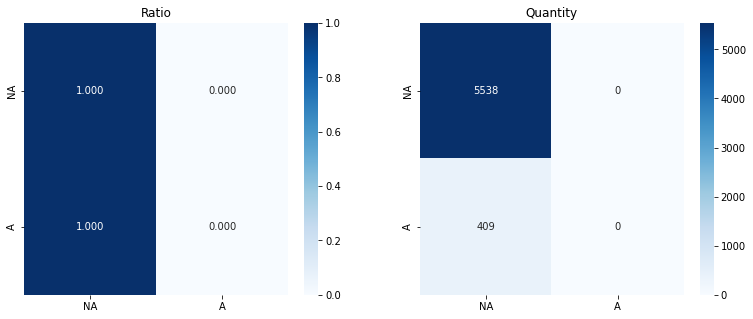

In [7]:
sleep_stage_true = collections.Counter(label_test)
A = sleep_stage_true[1]
NA = sleep_stage_true[0]
kind = ['NA','A']
sum_num = [[NA],[A]]

cm = tf.math.confusion_matrix(label_test,y_pre,num_classes)
cm_numpy = cm.numpy()
conf_df_ratio = pd.DataFrame(cm_numpy/(sum_num), index=kind ,columns=kind)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
conf_fig_ratio = sn.heatmap(conf_df_ratio, annot=True, fmt=".3f", cmap="Blues")
plt.title('Ratio')

conf_df = pd.DataFrame(cm_numpy, index=kind ,columns=kind)
plt.subplot(1,2,2)
conf_fig = sn.heatmap(conf_df, annot=True, fmt="d", cmap="Blues")
plt.title('Quantity')